# Predicting Bankruptcy in the mining industry with Altman's Z-score and the Calcbench API

Edward Altman's Z-score is a formula for predicting corporate bankruptcy. Below we plot the change in industry aggregate Z-scores for mining companies. A Z-score above 2.99 is considered "safe", between 1.81 and 2.99 is a "gray" zone, below 1.81 is the "distress" zone. The troubles in the coal and metal mining industry are clearly illustrated.

[Altman's Z-score @ Wikipedia](https://en.wikipedia.org/wiki/Altman_Z-score)

To replicate the below [sign up for a Calcbench account](https://www.calcbench.com/join), install the Calcbench Python API client from [here](https://github.com/calcbench/python_api_client) and download this note book from [github](https://github.com/calcbench/notebooks/blob/master/z-score.ipynb).


In [ ]:
%pip install "calcbench-api-client[Pandas]"

In [1]:
import calcbench as cb
import pandas as pd
from calcbench.api_query_params import PeriodType, Revisions

In [3]:
z_score_metrics = [
    "CurrentAssets",
    "CurrentLiabilities",
    "Assets",
    "RetainedEarnings",
    "EBIT",
    "MarketCapAtEndOfPeriod",
    "Liabilities",
    "Revenue",
]

In [88]:
SIC_codes = pd.DataFrame.from_records([
    ("Oil And Gas Extraction", 1300),
    ("Metal Mining", 1000),
    ("Coal Mining", 1200),
    ("Mining Nonmetallic Minerals", 1400),
], columns=['sic_title', 'sic_code'])

In [89]:
companies = cb.companies(SIC_codes=list(SIC_codes['sic_code']))
companies["sic_code"] = (companies["sic_code"] // 100) * 100 # Want only two levels of SIC code
companies = companies.merge(SIC_codes, left_on='sic_code', right_on='sic_code' )

In [102]:
cb_data = cb.standardized(
    company_identifiers=companies['ticker'],
    metrics=z_score_metrics,
    period_type=PeriodType.Annual,
    revisions=Revisions.MostRecent,
)

data = (
    cb_data.merge(companies.set_index('ticker'), right_index=True, left_on='ticker')
    .set_index("sic_title", append=True)
    .reorder_levels(["sic_title", "ticker", "metric", "fiscal_period"])
)

In [104]:
def z_score(inputs: pd.DataFrame):
    """
    https://en.wikipedia.org/wiki/Altman_Z-score
    """
    working_capital = inputs["CurrentAssets"] - inputs["CurrentLiabilities"]

    z_score = (
        1.2 * (working_capital / inputs["Assets"])
        + 1.4 * (inputs["RetainedEarnings"] / inputs["Assets"])
        + 3.3 * (inputs["EBIT"] / inputs["Assets"])
        + 0.6 * (inputs["MarketCapAtEndOfPeriod"] / inputs["Liabilities"])
        + 0.99 * (inputs["Revenue"] / inputs["Assets"])
    )
    z_score.name = "z_score"
    return z_score.to_frame()

In [106]:
unstacked_values = data.unstack("metric")["value"]
company_z_scores = z_score(unstacked_values)
bad_z_scores = (
    (company_z_scores < -10) | (company_z_scores > 10) | company_z_scores.isna()
)["z_score"]
unstacked_values = unstacked_values[~bad_z_scores]

data_summed = unstacked_values.groupby(level=["sic_title", "fiscal_period"]).sum()
z_scores = z_score(data_summed)

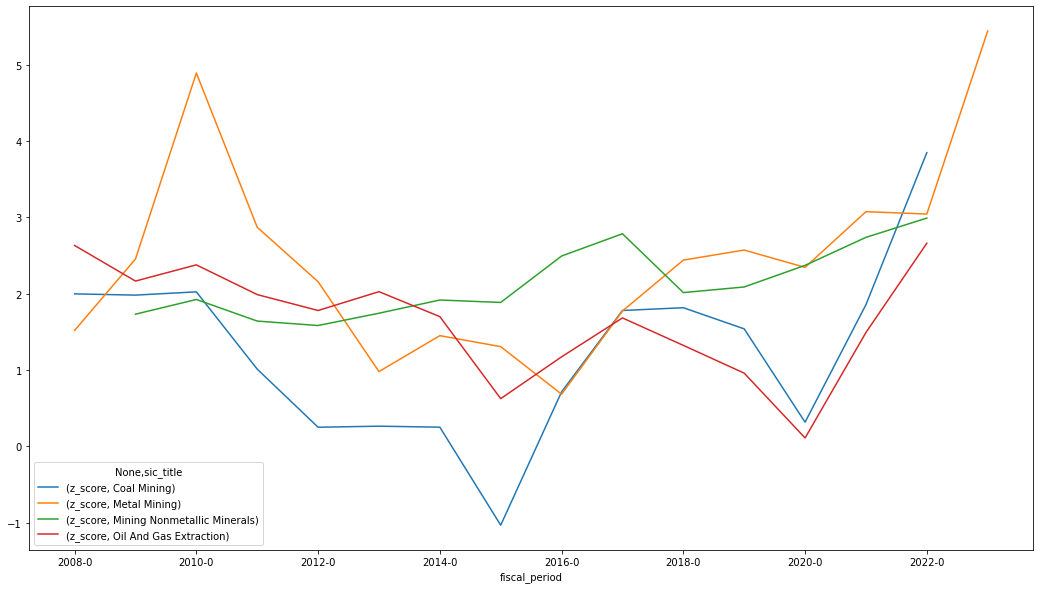

In [107]:
z_scores.unstack("sic_title").plot(figsize=(18, 10))